In [1]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

filename = list(uploaded.keys())[0]

df = pd.read_csv(filename)

df.columns = df.columns.str.strip()

df.head()

Saving TCS_10y_data.csv to TCS_10y_data.csv


,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover ₹,No. of Trades
0,TCS,EQ,01-Apr-15,"2,553.95","2,558.00","2,563.60","2,522.25","2,544.05","2,542.65","2,538.81","10,37,879","2,63,49,81,317.45","54,078"
1,TCS,EQ,06-Apr-15,"2,542.65","2,558.00","2,562.90","2,500.10","2,548.30","2,547.30","2,531.53","7,84,271","1,98,54,04,796.80","45,408"
2,TCS,EQ,07-Apr-15,"2,547.30","2,562.45","2,599.00","2,544.00","2,588.95","2,585.00","2,571.50","9,43,461","2,42,61,11,369.05","77,106"
3,TCS,EQ,08-Apr-15,"2,585.00","2,594.00","2,656.50","2,590.85","2,646.00","2,641.40","2,632.00","8,26,067","2,17,42,08,279.40","61,358"
4,TCS,EQ,09-Apr-15,"2,641.40","2,659.00","2,687.45","2,635.15","2,662.60","2,664.55","2,658.35","12,72,225","3,38,20,17,714.75","62,583"


**Preprocessing and EDA**

In [2]:
import pandas as pd
import numpy as np

# Check if 'Date' is already the index and reset it
if 'Date' in df.index.names:
    df = df.reset_index()

# 2. CLEAN COLUMN NAMES

df.columns = [col.strip().replace("₹", "").replace(" ", "_") for col in df.columns]

# 3. REMOVE ######## INVALID ENTRIES

df = df.replace("#######", np.nan)

# 4. CONVERT NUMERIC COLUMNS (REMOVE COMMAS)

numeric_cols = [
    "Prev_Close", "Open_Price", "High_Price", "Low_Price",
    "Last_Price", "Close_Price", "Average_Price", "Total_Traded_Quantity",
    "Turnover_", "No._of_Trades"
]

for col in numeric_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(float)
    )

# 5. PARSE DATE COLUMN & SORT

df["Date"] = pd.to_datetime(df["Date"], format="%d-%b-%y", errors="coerce")
df = df.dropna(subset=["Date"])     # drop rows where date failed parsing
df = df.sort_values("Date")

# 6. SET DATE AS INDEX

df = df.set_index("Date")

# Remove duplicate dates from the index
df = df[~df.index.duplicated(keep='first')]

# 7. RESAMPLE TO BUSINESS DAYS (B-FREQUENCY)
# Fill missing dates with NaN

df = df.asfreq("B")

# 8. INTERPOLATE CLOSE PRICE ONLY

df["Close_Price"] = df["Close_Price"].interpolate(method="linear")

# 9. FILL OTHER COLUMNS (forward-fill is typical for stock data)

df[numeric_cols] = df[numeric_cols].ffill() # Updated to use ffill() directly

# 10. FEATURE ENGINEERING
# Generate lag features

df["lag1"]  = df["Close_Price"].shift(1)
df["lag5"]  = df["Close_Price"].shift(5)
df["lag10"] = df["Close_Price"].shift(10)

# Rolling averages (trend estimators)
df["roll7"]  = df["Close_Price"].rolling(7).mean()
df["roll14"] = df["Close_Price"].rolling(14).mean()
df["roll30"] = df["Close_Price"].rolling(30).mean()

# Rolling volatility (risk)
df["vol7"]  = df["Close_Price"].rolling(7).std()
df["vol30"] = df["Close_Price"].rolling(30).std()

# 11. CREATE A STATIONARY SERIES FOR ARIMA

df["Close_diff"] = df["Close_Price"].diff()

# 12. DROP ROWS THAT STILL CONTAIN NaN

df = df.dropna()


print("Preprocessing complete!")
df.head()

Preprocessing complete!


,Symbol,Series,Prev_Close,Open_Price,High_Price,Low_Price,Last_Price,Close_Price,Average_Price,Total_Traded_Quantity,...,No._of_Trades,lag1,lag5,lag10,roll7,roll14,roll30,vol7,vol30,Close_diff
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-12,TCS,EQ,2556.00,2560.0,2565.00,2513.00,2523.95,2522.90,2524.91,1233693.0,...,71964.0,2556.00,2517.85,2495.000,2516.264286,2498.783929,2533.035000,33.224423,71.282345,-33.10
2015-05-13,TCS,EQ,2522.90,2547.0,2547.00,2480.45,2523.10,2515.40,2510.43,931887.0,...,53692.0,2522.90,2463.05,2487.300,2521.100000,2502.937500,2532.126667,29.594904,71.329203,-7.50
2015-05-14,TCS,EQ,2515.40,2520.0,2520.00,2485.00,2499.00,2499.25,2495.09,654525.0,...,40174.0,2515.40,2545.25,2463.700,2518.442857,2503.380357,2530.628333,30.747865,71.538647,-16.15
2015-05-15,TCS,EQ,2499.25,2515.0,2532.40,2501.00,2511.00,2511.15,2512.17,730727.0,...,32934.0,2499.25,2527.25,2472.625,2525.314286,2504.162500,2529.475000,19.693013,71.565354,11.90
2015-05-18,TCS,EQ,2511.15,2514.1,2525.25,2497.10,2515.15,2520.40,2505.41,2253876.0,...,50845.0,2511.15,2556.00,2481.550,2521.764286,2505.976786,2528.578333,17.632303,71.502810,9.25


In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.optimize import minimize

# 1. EXTRACT THE SERIES

data = df["Close_Price"].dropna().values
x = np.sort(data)

# 2. DEFINE BINORMAL (GAUSSIAN MIXTURE)

def binormal_pdf(x, w, mu1, sigma1, mu2, sigma2):
    return (
        w * st.norm.pdf(x, mu1, sigma1) +
        (1 - w) * st.norm.pdf(x, mu2, sigma2)
    )

def binormal_cdf(x, w, mu1, sigma1, mu2, sigma2):
    return (
        w * st.norm.cdf(x, mu1, sigma1) +
        (1 - w) * st.norm.cdf(x, mu2, sigma2)
    )

def fit_binormal(data):
    # Initial guesses
    w0 = 0.5
    mu1_0, mu2_0 = np.percentile(data, [30, 70])
    sigma1_0 = sigma2_0 = np.std(data) / 2

    def neg_log_likelihood(params):
        w, mu1, sigma1, mu2, sigma2 = params

        # Ensure valid parameters
        if sigma1 <= 0 or sigma2 <= 0 or not (0 < w < 1):
            return np.inf

        pdf_vals = binormal_pdf(data, w, mu1, sigma1, mu2, sigma2)
        pdf_vals = np.clip(pdf_vals, 1e-12, None)
        return -np.sum(np.log(pdf_vals))

    result = minimize(
        neg_log_likelihood,
        [w0, mu1_0, sigma1_0, mu2_0, sigma2_0],
        method="L-BFGS-B",
        bounds=[
            (0.001, 0.999),  # weight
            (None, None),
            (1e-6, None),
            (None, None),
            (1e-6, None),
        ]
    )

    return result.x  # fitted parameters


# 3. LIST OF CANDIDATE DISTRIBUTIONS

distributions = [
    st.norm,
    st.lognorm,
    st.expon,
    st.gamma,
    st.weibull_min,
    st.weibull_max,
    st.t,
    st.cauchy,
    st.laplace,
    "binormal",   # custom
]

results = []


# 4. FIT AND KS TEST

for dist in distributions:
    try:
        if dist == "binormal":
            params = fit_binormal(data)
            w, mu1, sigma1, mu2, sigma2 = params

            # Compute CDF of binormal at data points
            cdf_vals = binormal_cdf(x, w, mu1, sigma1, mu2, sigma2)

            # Empirical CDF
            ecdf = np.arange(1, len(x) + 1) / len(x)

            ks_stat = np.max(np.abs(ecdf - cdf_vals))
            # p-value approximation
            p_value = st.kstwobign.sf(ks_stat * np.sqrt(len(x)))

            results.append({
                "distribution": "binormal",
                "p_value": p_value,
                "ks_stat": ks_stat,
                "params": params
            })

        else:
            # Normal SciPy distributions
            params = dist.fit(data)
            ks_stat, p_value = st.kstest(data, dist.name, params)

            results.append({
                "distribution": dist.name,
                "p_value": p_value,
                "ks_stat": ks_stat,
                "params": params
            })

    except Exception as e:
        print(f"Error for {dist}: {e}")


# 5. SORT RESULTS

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("p_value", ascending=False)

print("Best fitting distributions (including Binormal):")
print(results_df.head(10))


Best fitting distributions (including Binormal):
  distribution       p_value   ks_stat  \
9     binormal  1.232199e-02  0.032275   
4  weibull_min  8.359718e-15  0.082191   
3        gamma  3.998097e-22  0.100945   
1      lognorm  2.205712e-22  0.101543   
6            t  5.724874e-33  0.123566   
0         norm  5.724783e-33  0.123566   
7       cauchy  2.066306e-49  0.151486   
8      laplace  9.471678e-65  0.173459   
2        expon  6.514435e-69  0.178946   
5  weibull_max  0.000000e+00  0.812896   

                                              params  
9  [0.5034292861755901, 2288.959291379935, 261.18...  
4  (1.8602510935342955, 1627.9049431138787, 1412....  
3  (3.133562940295809, 1558.280865364868, 422.232...  
1  (0.3692093027433046, 924.7872319076423, 1831.0...  
6  (3943519.163269338, 2881.372552527792, 700.181...  
0             (2881.372595169873, 700.1816948458996)  
7           (2685.9802089323352, 500.29694380631634)  
8                        (2675.4, 607.1563446582

In [4]:
params = fit_binormal(data)

w, mu1, sigma1, mu2, sigma2 = params

print("Binormal parameters:")
print(f"Weight (w):     {w}")
print(f"Mean 1 (mu1):   {mu1}")
print(f"Sigma 1:        {sigma1}")
print(f"Mean 2 (mu2):   {mu2}")
print(f"Sigma 2:        {sigma2}")


Binormal parameters:
Weight (w):     0.5034292861755901
Mean 1 (mu1):   2288.959291379935
Sigma 1:        261.18201864591185
Mean 2 (mu2):   3481.9374296248307
Sigma 2:        449.0044049512353


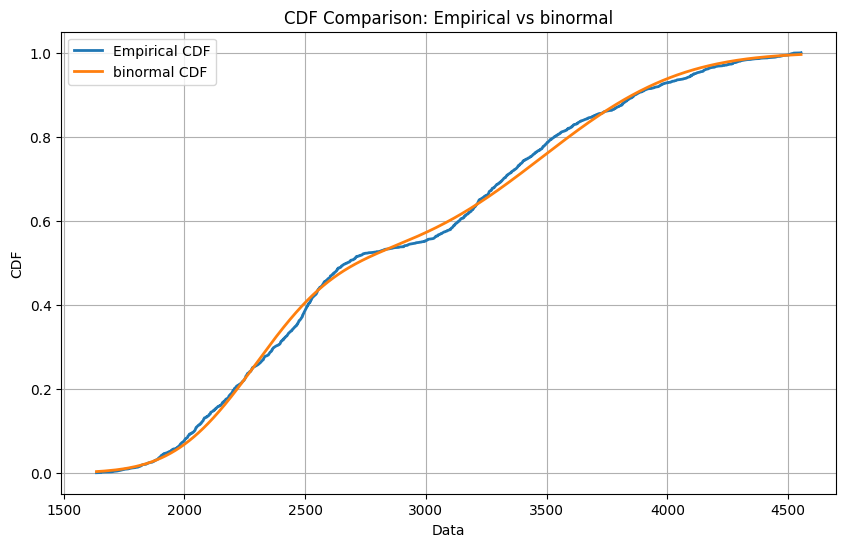

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# 1. Empirical CDF Function

def empirical_cdf(data):
    data_sorted = np.sort(data)
    n = len(data)
    ecdf = np.arange(1, n+1) / n
    return data_sorted, ecdf


# 2. Binormal CDF (Gaussian Mixture)

def binormal_cdf(x, w, mu1, sigma1, mu2, sigma2):
    return (
        w * st.norm.cdf(x, mu1, sigma1) +
        (1 - w) * st.norm.cdf(x, mu2, sigma2)
    )


# 3. Plot Function

def plot_cdf_comparison(data, dist_name, params):
    # Compute empirical CDF
    x_sorted, ecdf = empirical_cdf(data)

    # Compute model CDF
    if dist_name == "binormal":
        w, mu1, sigma1, mu2, sigma2 = params
        model_cdf = binormal_cdf(x_sorted, w, mu1, sigma1, mu2, sigma2)

    else:
        # SciPy distribution CDF
        dist = getattr(st, dist_name)
        model_cdf = dist.cdf(x_sorted, *params)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_sorted, ecdf, label="Empirical CDF", linewidth=2)
    plt.plot(x_sorted, model_cdf, label=f"{dist_name} CDF", linewidth=2)

    plt.title(f"CDF Comparison: Empirical vs {dist_name}")
    plt.xlabel("Data")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True)
    plt.show()




data = df["Close_Price"].dropna().values



binormal_params = fit_binormal(data)
plot_cdf_comparison(data, "binormal", binormal_params)


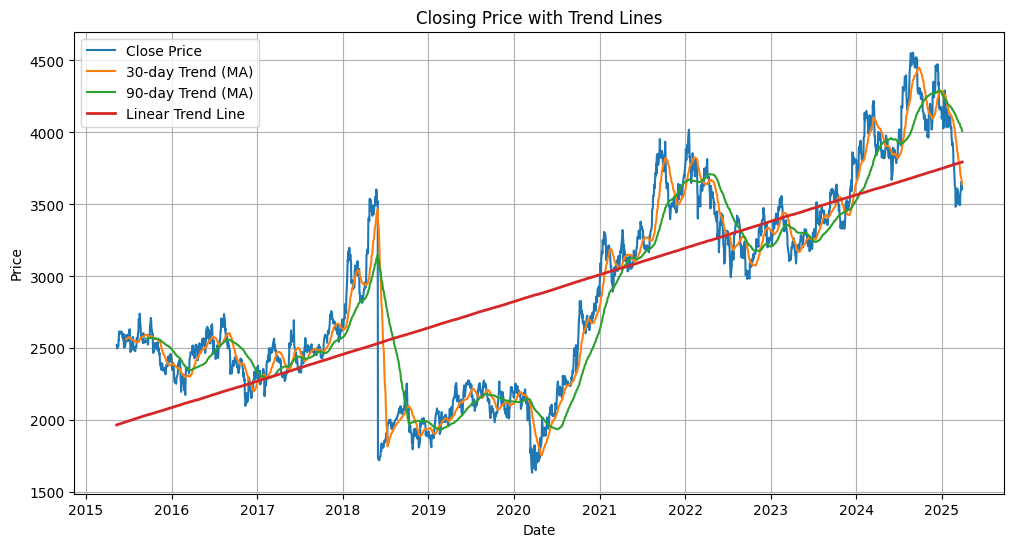

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute moving-average trends
df["trend_30"] = df["Close_Price"].rolling(30).mean()
df["trend_90"] = df["Close_Price"].rolling(90).mean()

# 2. Compute linear trend line (best-fit line)
x = np.arange(len(df))
y = df["Close_Price"].values

# Fit line: y = m*x + c
m, c = np.polyfit(x, y, 1)
df["linear_trend"] = m * x + c

# 3. Plot everything
plt.figure(figsize=(12,6))

plt.plot(df.index, df["Close_Price"], label="Close Price")
plt.plot(df.index, df["trend_30"], label="30-day Trend (MA)")
plt.plot(df.index, df["trend_90"], label="90-day Trend (MA)")
plt.plot(df.index, df["linear_trend"], label="Linear Trend Line", linewidth=2)

plt.legend()
plt.title("Closing Price with Trend Lines")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()



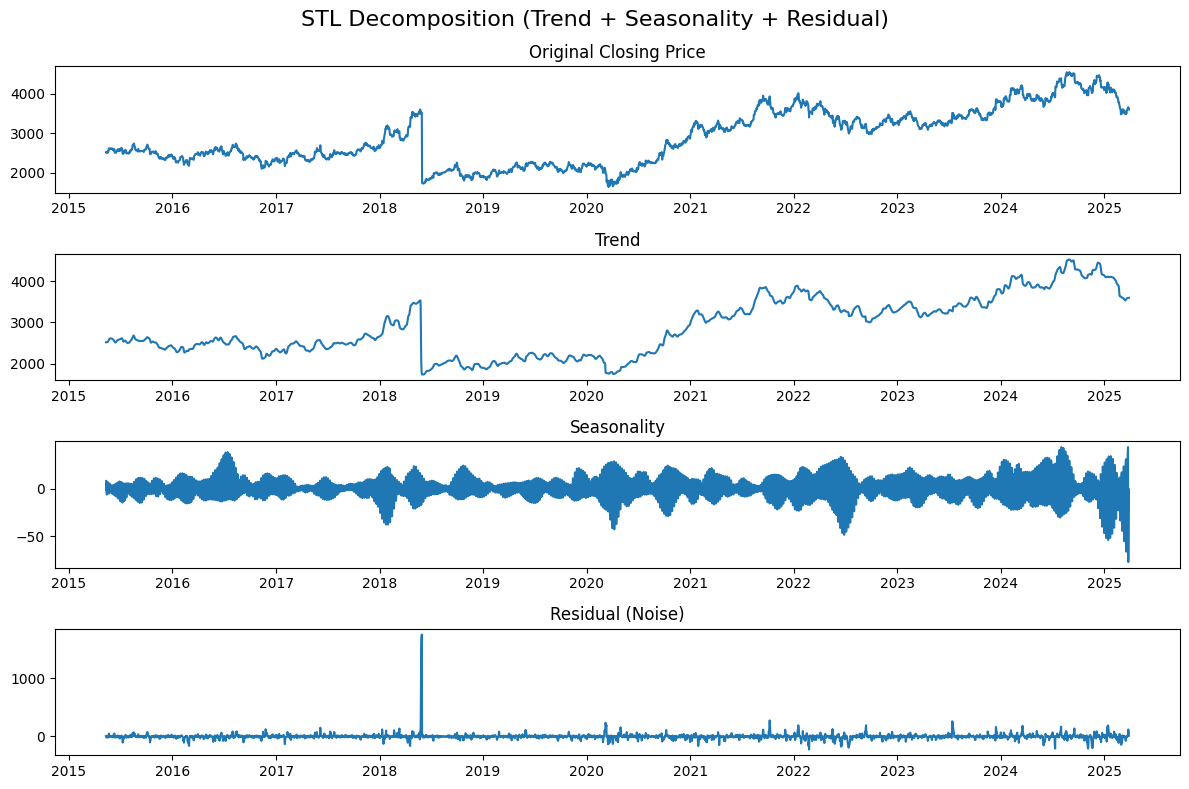

<Figure size 1200x800 with 0 Axes>

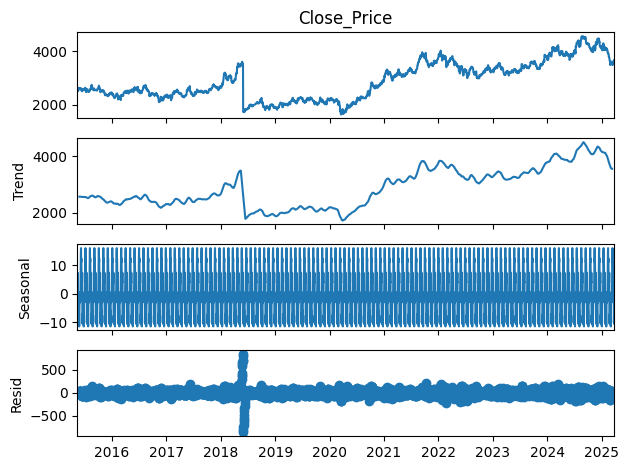

<Figure size 1200x800 with 0 Axes>

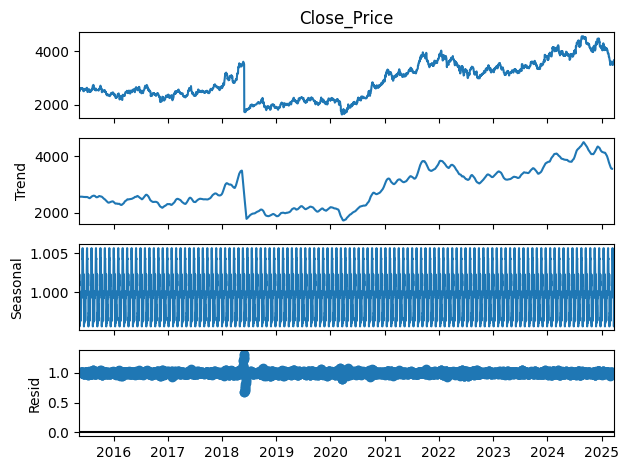

Trend Std Dev: 698.8876142970959
Seasonality Std Dev: 10.210491893256078
Residual Std Dev: 61.87868828279024

Interpretation:
- Larger seasonality std dev → stronger seasonal patterns
- Larger trend std dev → long-term movement dominates
- Larger residual std dev → noisy data


In [7]:
# Trend + Seasonality Analysis for Closing Prices

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL



# Enforce daily frequency for decomposition (interpolate if any new NaNs are introduced by asfreq)
df_daily = df.asfreq("D")
df_daily["Close_Price"] = df_daily["Close_Price"].interpolate()   # fill missing values smoothly

# 2. STL Decomposition (preferred)
stl = STL(df_daily["Close_Price"], seasonal=13, robust=True)
stl_res = stl.fit()

plt.figure(figsize=(12,8))
plt.suptitle("STL Decomposition (Trend + Seasonality + Residual)", fontsize=16)

plt.subplot(4,1,1)
plt.plot(df_daily["Close_Price"])
plt.title("Original Closing Price")

plt.subplot(4,1,2)
plt.plot(stl_res.trend)
plt.title("Trend")

plt.subplot(4,1,3)
plt.plot(stl_res.seasonal)
plt.title("Seasonality")

plt.subplot(4,1,4)
plt.plot(stl_res.resid)
plt.title("Residual (Noise)")

plt.tight_layout()
plt.show()

# 3. Seasonal Decomposition (Additive & Multiplicative)

# ---- Additive model ----
additive_res = seasonal_decompose(df_daily["Close_Price"], model="additive", period=30)

plt.figure(figsize=(12,8))
plt.suptitle("Additive Seasonal Decomposition", fontsize=16)
additive_res.plot()
plt.show()

# ---- Multiplicative model ----
multiplicative_res = seasonal_decompose(df_daily["Close_Price"], model="multiplicative", period=30)

plt.figure(figsize=(12,8))
plt.suptitle("Multiplicative Seasonal Decomposition", fontsize=16)
multiplicative_res.plot()
plt.show()


print("Trend Std Dev:", stl_res.trend.std())
print("Seasonality Std Dev:", stl_res.seasonal.std())
print("Residual Std Dev:", stl_res.resid.std())
print("\nInterpretation:")
print("- Larger seasonality std dev \u2192 stronger seasonal patterns")
print("- Larger trend std dev \u2192 long-term movement dominates")
print("- Larger residual std dev \u2192 noisy data")

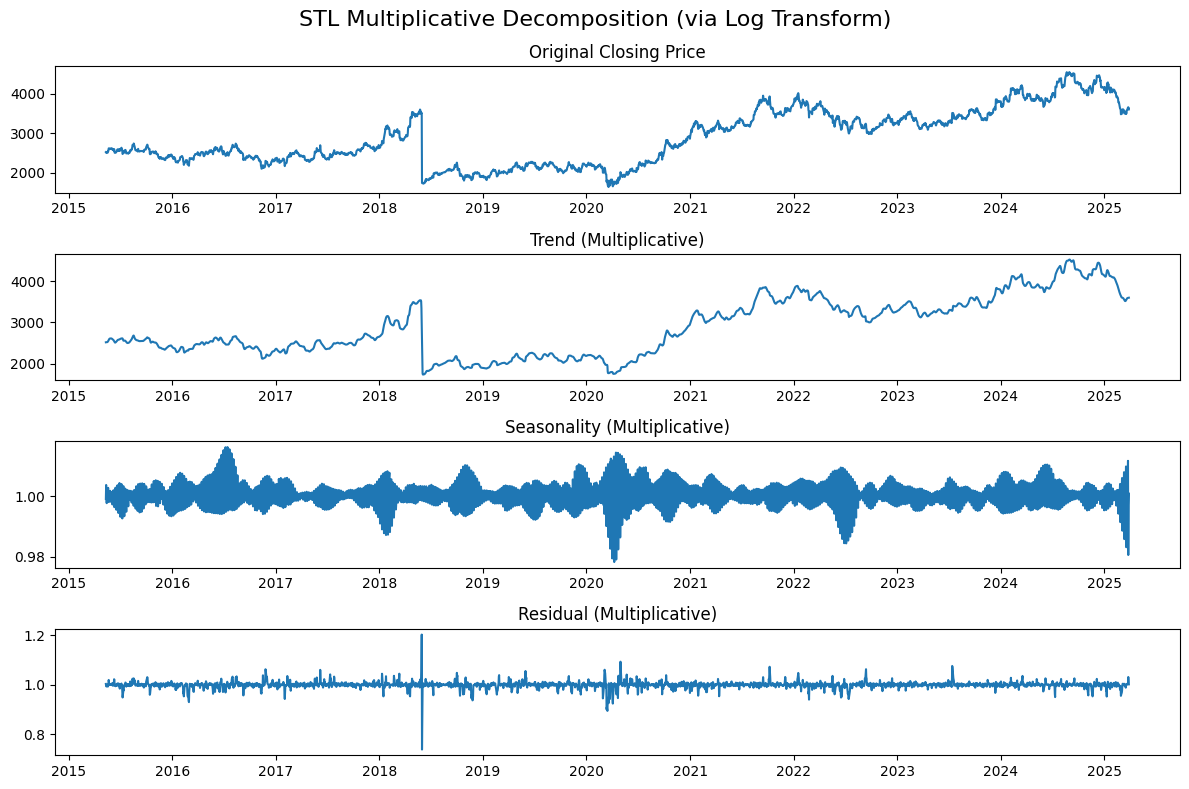

<Figure size 1200x800 with 0 Axes>

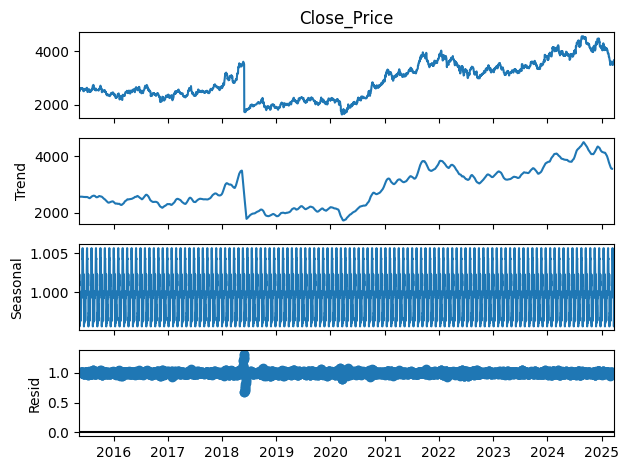

Trend Std Dev: 697.9345475981473
Seasonality Std Dev: 0.0033211497257306286
Residual Std Dev: 0.014039162820058671

Interpretation:
- Higher seasonality std dev → stronger % seasonal cycles
- Higher trend std dev → long-term % movement dominates
- Higher residual std dev → more volatility


In [8]:
# --- Multiplicative Seasonal Decomposition for Closing Prices ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# 1. Load and prepare the data
df_daily = df.asfreq("D")
df_daily["Close_Price"] = df_daily["Close_Price"].interpolate()

# 2. MULTIPLICATIVE STL (via log transform)
# STL is additive → convert series by log, then exponentiate components later
log_series = np.log(df_daily["Close_Price"])

stl = STL(log_series, seasonal=13, robust=True)
stl_res = stl.fit()

# Convert additive STL components into multiplicative ones
trend_mult = np.exp(stl_res.trend)
seasonal_mult = np.exp(stl_res.seasonal)
resid_mult = np.exp(stl_res.resid)

plt.figure(figsize=(12,8))
plt.suptitle("STL Multiplicative Decomposition (via Log Transform)", fontsize=16)

plt.subplot(4,1,1)
plt.plot(df_daily["Close_Price"])
plt.title("Original Closing Price")

plt.subplot(4,1,2)
plt.plot(trend_mult)
plt.title("Trend (Multiplicative)")

plt.subplot(4,1,3)
plt.plot(seasonal_mult)
plt.title("Seasonality (Multiplicative)")

plt.subplot(4,1,4)
plt.plot(resid_mult)
plt.title("Residual (Multiplicative)")

plt.tight_layout()
plt.show()

# 4. Classical MULTIPLICATIVE decomposition
multiplicative_res = seasonal_decompose(
    df_daily["Close_Price"],
    model="multiplicative",
    period=30
)

plt.figure(figsize=(12,8))
plt.suptitle("Classical Multiplicative Seasonal Decomposition", fontsize=16)
multiplicative_res.plot()
plt.show()

print("Trend Std Dev:", trend_mult.std())
print("Seasonality Std Dev:", seasonal_mult.std())
print("Residual Std Dev:", resid_mult.std())

print("\nInterpretation:")
print("- Higher seasonality std dev → stronger % seasonal cycles")
print("- Higher trend std dev → long-term % movement dominates")
print("- Higher residual std dev → more volatility")


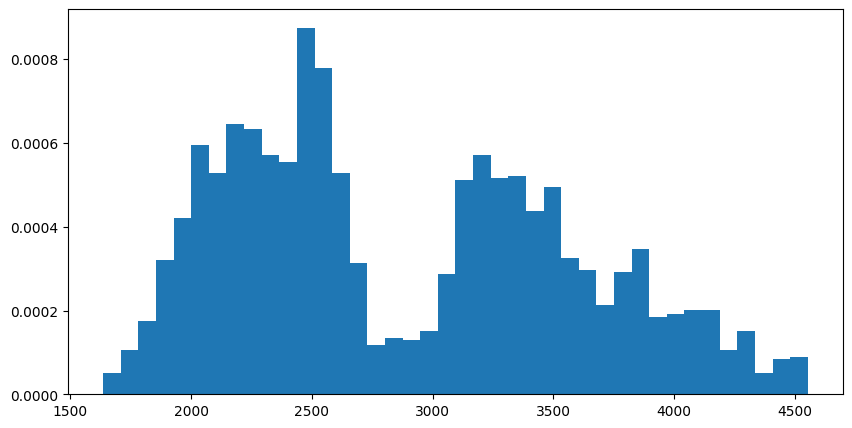

In [9]:
plt.figure(figsize=(10,5))
plt.hist(data, bins=40, density=True)
plt.show()


In [10]:
data_orig = df["Close_Price"].dropna().values

# Min-max scaling
data_min, data_max = np.min(data_orig), np.max(data_orig)
data = (data_orig - data_min) / (data_max - data_min)
x_vals = np.linspace(0, 1, 500)


/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:6930: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


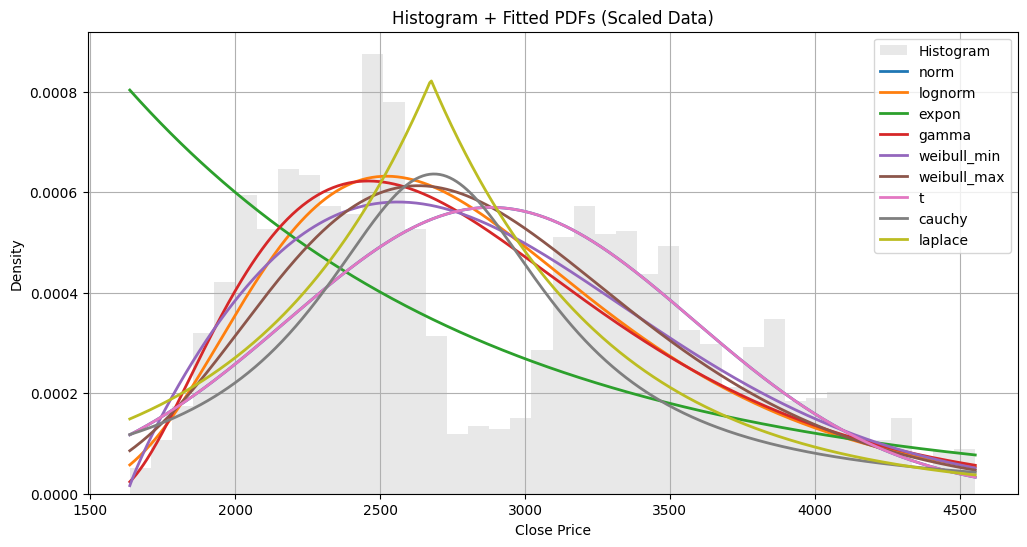

In [11]:
plt.figure(figsize=(12,6))
# Histogram in original scale
plt.hist(data_orig, bins=40, density=True, alpha=0.5, color="lightgray", label="Histogram")

# PDFs — rescale x_vals to original scale
x_vals_orig = x_vals*(data_max - data_min) + data_min

# Plot PDFs
for dist in distributions:
    try:
        if dist == "binormal":
            params = fit_binormal(data)
            pdf_vals = binormal_pdf_scaled(x_vals, *params)
            label = "Binormal"
        else:
            params = dist.fit(data)
            pdf_vals = dist.pdf(x_vals, *params) / (data_max - data_min)
            label = dist.name

        plt.plot(x_vals_orig, pdf_vals, linewidth=2, label=label)
    except:
        continue

plt.title("Histogram + Fitted PDFs (Scaled Data)")
plt.xlabel("Close Price")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


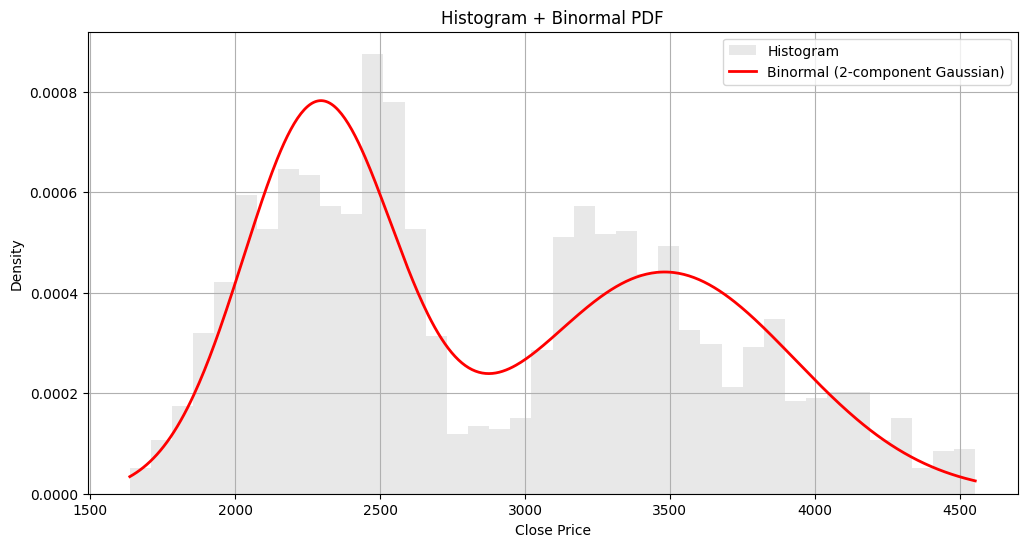

Binormal parameters:
w=0.5033930952617259, mu1=2288.9445484243142, sigma1=261.1644581026198, mu2=3481.8450694469507, sigma2=449.06197562344977


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.optimize import minimize

# Original data
data = df["Close_Price"].dropna().values
x_vals = np.linspace(np.min(data), np.max(data), 500)

# ---------- Binormal (Gaussian mixture) ----------
def binormal_pdf(x, w, mu1, sigma1, mu2, sigma2):
    return w*st.norm.pdf(x, mu1, sigma1) + (1-w)*st.norm.pdf(x, mu2, sigma2)

def fit_binormal(data):
    w0 = 0.5
    mu1_0, mu2_0 = np.percentile(data, [40, 60])  # better initial guess
    sigma1_0 = sigma2_0 = np.std(data)/4          # smaller std

    def neg_ll(params):
        w, mu1, sigma1, mu2, sigma2 = params
        if sigma1<=0 or sigma2<=0 or not (0<w<1):
            return np.inf
        pdf_vals = binormal_pdf(data, w, mu1, sigma1, mu2, sigma2)
        pdf_vals = np.clip(pdf_vals, 1e-12, None)
        return -np.sum(np.log(pdf_vals))

    result = minimize(neg_ll, [w0, mu1_0, sigma1_0, mu2_0, sigma2_0],
                      method="L-BFGS-B",
                      bounds=[(0.001,0.999),(None,None),(1e-6,None),(None,None),(1e-6,None)])
    return result.x

# Fit binormal
params_binormal = fit_binormal(data)
pdf_binormal = binormal_pdf(x_vals, *params_binormal)

# ---------- Plot histogram + binormal ----------
plt.figure(figsize=(12,6))
plt.hist(data, bins=40, density=True, alpha=0.5, color="lightgray", label="Histogram")
plt.plot(x_vals, pdf_binormal, linewidth=2, color="red", label="Binormal (2-component Gaussian)")
plt.title("Histogram + Binormal PDF")
plt.xlabel("Close Price")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Print parameters
w, mu1, sigma1, mu2, sigma2 = params_binormal
print(f"Binormal parameters:\nw={w}, mu1={mu1}, sigma1={sigma1}, mu2={mu2}, sigma2={sigma2}")


<Figure size 1000x400 with 0 Axes>

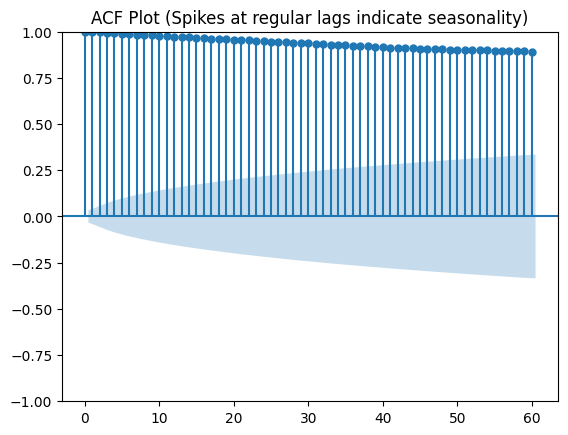


=== Ljung–Box Seasonality Test ===
          lb_stat  lb_pvalue
12   42147.180684        0.0
24   82264.601763        0.0
30  101634.889906        0.0

Interpretation:
- p-value < 0.05 means autocorrelation is statistically significant.
- Significant autocorrelation at seasonal lags → seasonality present.


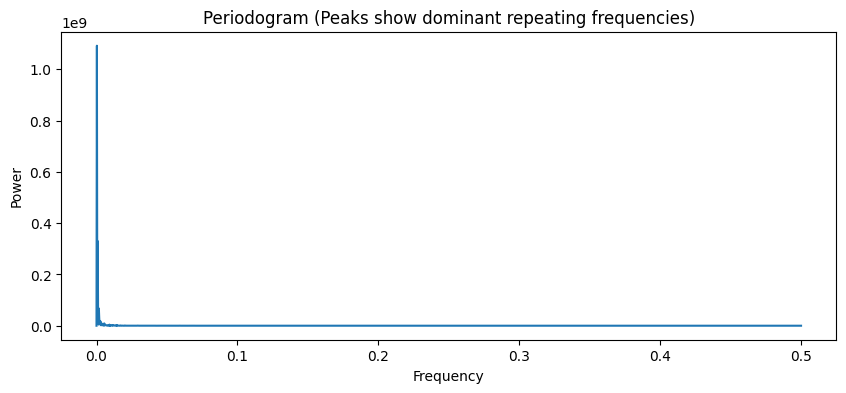


=== Periodogram Seasonality Check ===
Dominant Frequency: 0.0002770850651149903
Estimated Seasonal Period: 3608

=== Seasonality Strength (STL) ===
Seasonal Strength: -0.002

Interpretation:
- >0.64 = strong seasonality
- 0.2–0.64 = weak to moderate
- <0.2 = no meaningful seasonality


In [13]:
# CHECKING SEASONALITY IN CLOSING PRICE TIME SERIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import periodogram
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL

# The 'df_daily' DataFrame is already preprocessed and available from previous cells.
ts = df_daily["Close_Price"]

# 2. ACF Test for seasonality
plt.figure(figsize=(10,4))
plot_acf(ts, lags=60)
plt.title("ACF Plot (Spikes at regular lags indicate seasonality)")
plt.show()

# 3. Ljung–Box Test
lb = acorr_ljungbox(ts, lags=[12, 24, 30], return_df=True)
print("\n=== Ljung–Box Seasonality Test ===")
print(lb)
print("\nInterpretation:")
print("- p-value < 0.05 means autocorrelation is statistically significant.")
print("- Significant autocorrelation at seasonal lags → seasonality present.")

# 4. Periodogram / FFT peak test
freqs, power = periodogram(ts)

plt.figure(figsize=(10,4))
plt.plot(freqs, power)
plt.title("Periodogram (Peaks show dominant repeating frequencies)")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()

# Find the dominant frequency (excluding zero)
dominant_freq = freqs[np.argmax(power[1:]) + 1]
season_period = int(1 / dominant_freq) if dominant_freq != 0 else None

print("\n=== Periodogram Seasonality Check ===")
print("Dominant Frequency:", dominant_freq)
print("Estimated Seasonal Period:", season_period)

# 5. STL Seasonal Strength
stl = STL(ts, seasonal=13, robust=True).fit()

season_strength = 1 - (np.var(stl.resid) / (np.var(stl.resid + stl.seasonal)))
print("\n=== Seasonality Strength (STL) ===")
print(f"Seasonal Strength: {season_strength:.3f}")

print("\nInterpretation:")
print("- >0.64 = strong seasonality")
print("- 0.2–0.64 = weak to moderate")
print("- <0.2 = no meaningful seasonality")

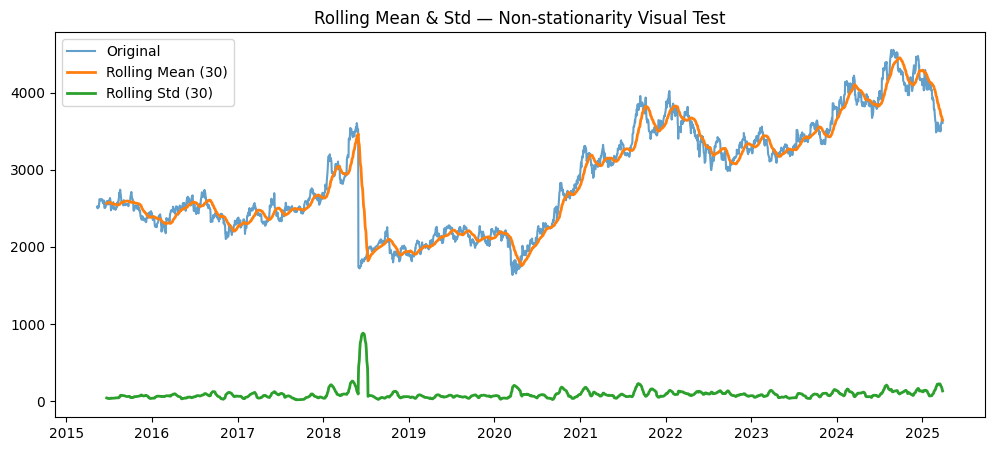


=========== ADF TEST ===========
ADF Statistic : -1.8385927328068246
p-value       : 0.361476696015011
Critical Values:
   1% : -3.4330306663366255
   5% : -2.862724291785039
   10% : -2.56740044647283

→ ADF says: NOT stationary (fail to reject H0)

=========== KPSS TEST ===========
KPSS Statistic : 5.187627820391031
p-value        : 0.01
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739

→ KPSS says: NOT stationary (reject H0)

=========== FINAL INTERPRETATION ===========

Combine ADF & KPSS:

CASE 1: ADF = stationary AND KPSS = stationary
        → Data is STATIONARY

CASE 2: ADF = non-stationary AND KPSS = non-stationary
        → Definitely NON-STATIONARY

CASE 3: ADF = stationary BUT KPSS = non-stationary
        → Trend-stationary (needs detrending)

CASE 4: ADF = non-stationary BUT KPSS = stationary
        → Difference-stationary (needs differencing)



/tmp/ipython-input-155061678.py:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, crit = kpss(series, regression='c', nlags="auto")


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss


ts = df["Close_Price"]

# 1. VISUAL CHECK — Rolling Mean & Variance

plt.figure(figsize=(12,5))
plt.plot(ts, label="Original", alpha=0.7)
plt.plot(ts.rolling(30).mean(), label="Rolling Mean (30)", linewidth=2)
plt.plot(ts.rolling(30).std(),  label="Rolling Std (30)", linewidth=2)
plt.legend()
plt.title("Rolling Mean & Std — Non-stationarity Visual Test")
plt.show()


# 2. ADF TEST (Null hypothesis: NON-stationary)

adf_result = adfuller(ts.dropna())
print("\n=========== ADF TEST ===========")
print(f"ADF Statistic : {adf_result[0]}")
print(f"p-value       : {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key} : {value}")

if adf_result[1] < 0.05:
    print("\n→ ADF says: Stationary (reject H0)")
else:
    print("\n→ ADF says: NOT stationary (fail to reject H0)")


# 3. KPSS TEST (Null hypothesis: Stationary)

def kpss_test(series):
    statistic, p_value, _, crit = kpss(series, regression='c', nlags="auto")
    print("\n=========== KPSS TEST ===========")
    print(f"KPSS Statistic : {statistic}")
    print(f"p-value        : {p_value}")
    print("Critical Values:")
    for key, value in crit.items():
        print(f"   {key} : {value}")

    if p_value < 0.05:
        print("\n→ KPSS says: NOT stationary (reject H0)")
    else:
        print("\n→ KPSS says: Stationary (fail to reject H0)")

kpss_test(ts.dropna())



print("\n=========== FINAL INTERPRETATION ===========")
print("""
Combine ADF & KPSS:

CASE 1: ADF = stationary AND KPSS = stationary
        → Data is STATIONARY

CASE 2: ADF = non-stationary AND KPSS = non-stationary
        → Definitely NON-STATIONARY

CASE 3: ADF = stationary BUT KPSS = non-stationary
        → Trend-stationary (needs detrending)

CASE 4: ADF = non-stationary BUT KPSS = stationary
        → Difference-stationary (needs differencing)
""")

In [15]:
from statsmodels.tsa.seasonal import STL
import pandas as pd

series = df['Close_Price']

stl = STL(series, period=12).fit()   # change period depending on frequency
seasonal = stl.seasonal
resid = stl.resid

# Seasonal strength calculation
from numpy import var

F_s = max(0, 1 - var(resid) / var(seasonal + resid))
print("Seasonal Strength =", F_s)


Seasonal Strength = 0.31018479989804637


In [16]:
import pandas as pd

# Select the target series (closing price)
ts = df["Close_Price"]

# 2. Time-Series Split
# Choose how many days you want for testing
test_size = 30   # last 30 days will be used as test set

train = ts[:-test_size]   # all except last 30 days
test  = ts[-test_size:]   # last 30 days only

print("TRAIN start:", train.index.min(), "  end:", train.index.max())
print("TEST  start:", test.index.min(),  "  end:", test.index.max())
print("\nTrain size:", len(train))
print("Test size :", len(test))

TRAIN start: 2015-05-12 00:00:00   end: 2025-02-12 00:00:00
TEST  start: 2025-02-13 00:00:00   end: 2025-03-28 00:00:00

Train size: 2413
Test size : 30


**AutoRegressive Forecasting Model**

Train size: 2413
Test size: 30


<Figure size 1000x500 with 0 Axes>

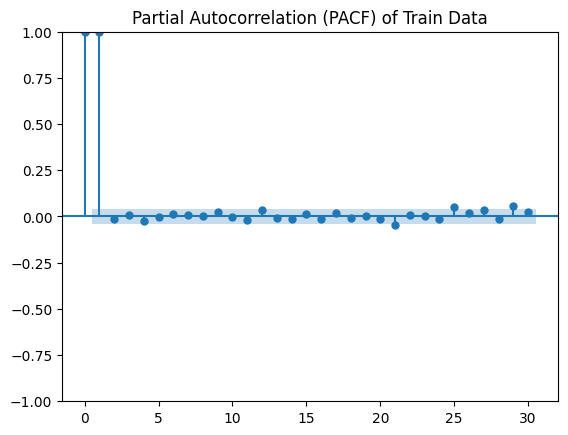

Suggested AR lag (p) based on PACF: 1

Model Summary:
                            AutoReg Model Results                             
Dep. Variable:            Close_Price   No. Observations:                 2413
Model:                     AutoReg(1)   Log Likelihood              -13091.783
Method:               Conditional MLE   S.D. of innovations             55.083
Date:                Sun, 23 Nov 2025   AIC                          26189.566
Time:                        05:06:11   BIC                          26206.931
Sample:                             1   HQIC                         26195.882
                                 2413                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.2491      4.742      1.740      0.082      -1.045      17.543
Close_Price.L1     0.9973      0.002    621.576      0.000       

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the po

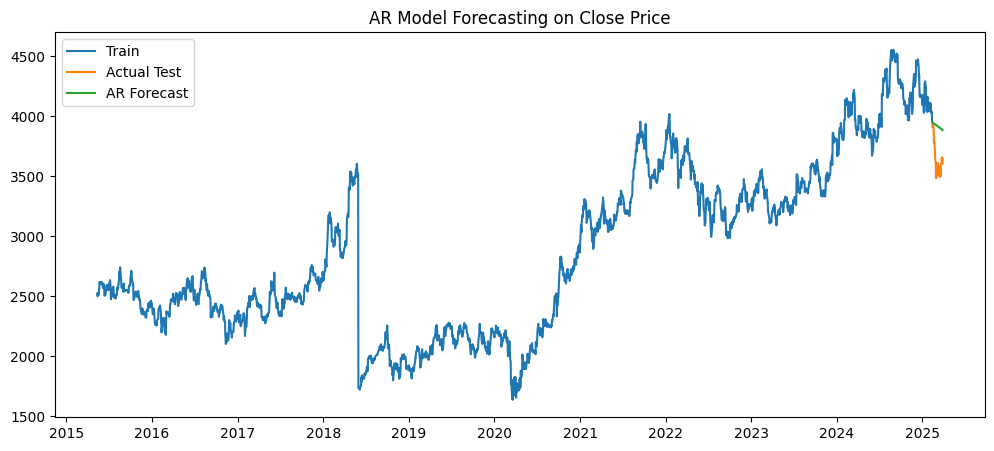


=== Forecasted Values ===
Date
2025-02-13    3947.865295
2025-02-14    3945.586683
2025-02-17    3943.314148
2025-02-18    3941.047672
2025-02-19    3938.787240
2025-02-20    3936.532837
2025-02-21    3934.284445
2025-02-24    3932.042048
2025-02-25    3929.805632
2025-02-27    3927.575179
2025-02-28    3925.350674
2025-03-03    3923.132101
2025-03-04    3920.919444
2025-03-05    3918.712688
2025-03-06    3916.511817
2025-03-07    3914.316814
2025-03-10    3912.127665
2025-03-11    3909.944354
2025-03-12    3907.766864
2025-03-13    3905.595182
2025-03-17    3903.429290
2025-03-18    3901.269175
2025-03-19    3899.114819
2025-03-20    3896.966209
2025-03-21    3894.823328
2025-03-24    3892.686162
2025-03-25    3890.554694
2025-03-26    3888.428911
2025-03-27    3886.308796
2025-03-28    3884.194336
dtype: float64


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf

ts = df["Close_Price"]

test_size = 30    # forecast last 30 days
train = ts[:-test_size]
test  = ts[-test_size:]

print("Train size:", len(train))
print("Test size:",  len(test))

# 3. Analyse PACF to suggest AR lag (p)
plt.figure(figsize=(10,5))
pacf_plot = plot_pacf(train, lags=30, method='ywm', alpha=0.05)
plt.title("Partial Autocorrelation (PACF) of Train Data")
plt.show()

# Suggest p as the first significant PACF lag
from statsmodels.tsa.stattools import pacf
pacf_values = pacf(train, nlags=30, method='ywm')
significant_lags = np.where(np.abs(pacf_values) > 1.96/np.sqrt(len(train)))[0]
if len(significant_lags) > 0:
    # Using index 1 to ignore lag 0 which is always 1
    suggested_p = significant_lags[1] if len(significant_lags) > 1 else 1
else:
    suggested_p = 1  # fallback

print(f"Suggested AR lag (p) based on PACF: {suggested_p}")

# 4. Fit final AR model with suggested p
final_model = AutoReg(train, lags=suggested_p, old_names=False).fit()
print("\nModel Summary:")
print(final_model.summary())

# 5. Forecast on the test set horizon
pred = final_model.predict(start=len(train), end=len(train)+len(test)-1)
# Assign the correct DatetimeIndex to the predictions for alignment
pred.index = test.index

# 6. Plot the forecast results
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index,  test, label="Actual Test")
plt.plot(test.index,  pred, label="AR Forecast")
plt.title("AR Model Forecasting on Close Price")
plt.legend()
plt.show()

# 7. Print forecasted values
print("\n=== Forecasted Values ===")
print(pred)

In [18]:
# 8. Calculate MAPE
actual = test.values
forecast = pred.values

mape = np.mean(np.abs((actual - forecast) / actual)) * 100

print("\n=== Forecast Accuracy ===")
print(f"MAPE: {mape:.2f}%")



=== Forecast Accuracy ===
MAPE: 7.69%


In [19]:
train_resid = final_model.resid
train_mse   = np.mean(train_resid**2)
train_rmse  = np.sqrt(train_mse)

print("Training MSE:", train_mse)
print("Training RMSE:", train_rmse)

# Forecast Accuracy

mse  = np.mean((test - pred)**2)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(test - pred))
mape = np.mean(np.abs((test - pred) / test)) * 100

print("Forecast MSE :", mse)
print("Forecast RMSE:", rmse)
print("Forecast MAE :", mae)
print("Forecast MAPE:", mape)

Training MSE: 3034.0832012724413
Training RMSE: 55.08251266302619
Forecast MSE : 90231.74743562123
Forecast RMSE: 300.38599740271053
Forecast MAE : 275.34481679055136
Forecast MAPE: 7.688126779121535


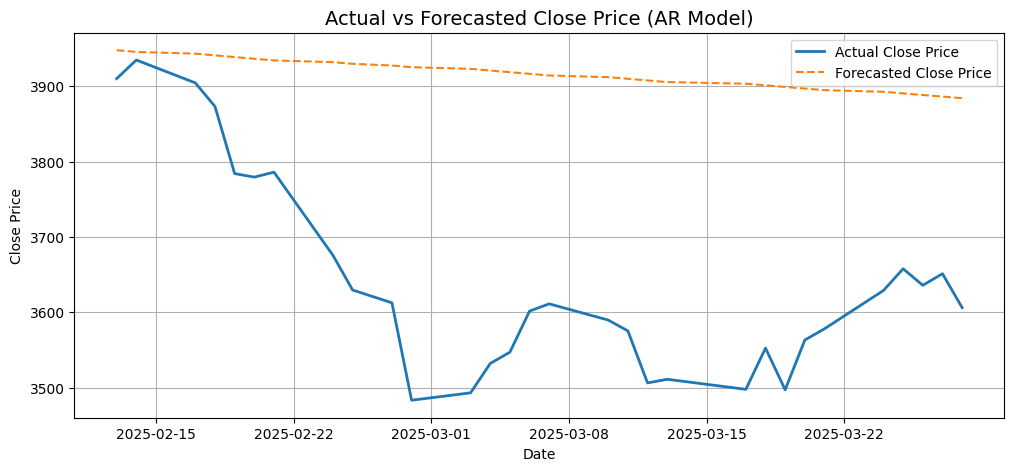

In [22]:
plt.figure(figsize=(12,5))

# Plot actual test values
plt.plot(test.index, test, label="Actual Close Price", linewidth=2)

# Plot AR model forecast
plt.plot(test.index, pred, label="Forecasted Close Price", linestyle='--')

plt.title("Actual vs Forecasted Close Price (AR Model)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


**ARMA Forecasting Model**

Train size: 2413
Test size: 30
                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                 2413
Model:                 ARIMA(0, 2, 0)   Log Likelihood              -13909.802
Date:                Sun, 23 Nov 2025   AIC                          27821.605
Time:                        05:11:09   BIC                          27827.393
Sample:                             0   HQIC                         27823.710
                               - 2413                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6007.3543     16.377    366.818      0.000    5975.256    6039.453
Ljung-Box (L1) (Q):                 561.29   Jarque-Bera (JB):           4916950.08
Prob(Q):        

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

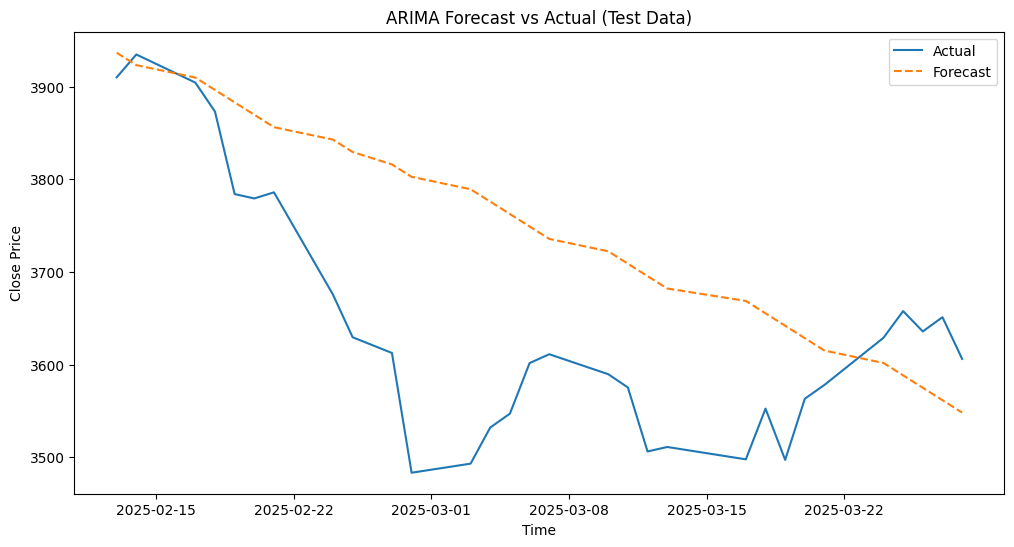

ARIMA Train RMSE: 96.49598741108176
ARIMA Train MAE : 46.3196136103406


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Load your preprocessed data
ts = df["Close_Price"]

# 2. Train/Test Split  (no shuffling)
test_size = 30    # forecast last 30 days
train = ts[:-test_size]
test  = ts[-test_size:]

print("Train size:", len(train))
print("Test size:",  len(test))

# Fit the ARIMA(p,d,q) Model
p = 0
d = 2 # differencing order (set based on stationarity)
q = 0

arima_model = ARIMA(train, order=(p, d, q))
arima_fit = arima_model.fit()

print(arima_fit.summary())

# Forecast on Test Data
start = len(train)
end = len(train) + len(test) - 1

arima_forecast = arima_fit.predict(start=start, end=end, typ='levels')
# Assign the correct DatetimeIndex to the predictions for alignment
arima_forecast.index = test.index

rmse_test = np.sqrt(mean_squared_error(test, arima_forecast))
mae_test = mean_absolute_error(test, arima_forecast)

print("ARIMA Test RMSE:", rmse_test)
print("ARIMA Test MAE :", mae_test)

# Plot Actual vs Forecast (Test Data)
plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, label="Actual")
plt.plot(test.index, arima_forecast, label="Forecast", linestyle='dashed')
plt.title("ARIMA Forecast vs Actual (Test Data)")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Training (in-sample) predictions
train_pred = arima_fit.predict(start=0, end=len(train)-1, typ='levels')

rmse_train = np.sqrt(mean_squared_error(train, train_pred))
mae_train = mean_absolute_error(train, train_pred)

print("ARIMA Train RMSE:", rmse_train)
print("ARIMA Train MAE :", mae_train)

**ARIMA Forecasting Model**

In [27]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Define parameter search space
p_values = range(0, 4)   # try p = 0,1,2,3
d_values = range(0, 3)   # try d = 0,1,2
q_values = range(0, 4)   # try q = 0,1,2,3

best_mape = float('inf')
best_order = None
best_model = None
best_forecast = None

print("Searching best ARIMA model...")

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()

        # Forecast test period
        forecast = model_fit.predict(start=len(train),
                                     end=len(train) + len(test) - 1,
                                     typ='levels')

        # Align index
        forecast.index = test.index

        mape = mean_absolute_percentage_error(test, forecast) * 100

        print(f"Trying ARIMA({p},{d},{q})  →  Test MAPE = {mape:.3f}%")

        if mape < best_mape:
            best_mape = mape
            best_order = (p, d, q)
            best_model = model_fit
            best_forecast = forecast

    except:
        continue

# FINAL BEST MODEL
print("\n==================================")
print(f"Best ARIMA order : {best_order}")
print(f"Best Test MAPE   : {best_mape:.3f}%")
print("==================================")



Searching best ARIMA model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Trying ARIMA(0,0,0)  →  Test MAPE = 21.010%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(0,0,1)  →  Test MAPE = 20.560%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(0,0,2)  →  Test MAPE = 22.817%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(0,0,3)  →  Test MAPE = 19.543%
Trying ARIMA(0,1,0)  →  Test MAPE = 8.649%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(0,1,1)  →  Test MAPE = 8.645%
Trying ARIMA(0,1,2)  →  Test MAPE = 8.703%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(0,1,3)  →  Test MAPE = 8.645%
Trying ARIMA(0,2,0)  →  Test MAPE = 3.445%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(0,2,1)  →  Test MAPE = 8.917%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(0,2,2)  →  Test MAPE = 8.911%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(0,2,3)  →  Test MAPE = 8.960%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(1,0,0)  →  Test MAPE = 7.295%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(1,0,1)  →  Test MAPE = 7.396%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(1,0,2)  →  Test MAPE = 7.507%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(1,0,3)  →  Test MAPE = 7.392%
Trying ARIMA(1,1,0)  →  Test MAPE = 8.645%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(1,1,1)  →  Test MAPE = 8.678%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(1,1,2)  →  Test MAPE = 8.700%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(1,1,3)  →  Test MAPE = 8.653%
Trying ARIMA(1,2,0)  →  Test MAPE = 6.072%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(1,2,1)  →  Test MAPE = 8.921%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(1,2,2)  →  Test MAPE = 8.935%


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/loc

Trying ARIMA(1,2,3)  →  Test MAPE = 8.957%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(2,0,0)  →  Test MAPE = 7.398%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(2,0,1)  →  Test MAPE = 7.291%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(2,0,2)  →  Test MAPE = 7.352%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(2,0,3)  →  Test MAPE = 7.371%
Trying ARIMA(2,1,0)  →  Test MAPE = 8.701%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(2,1,1)  →  Test MAPE = 8.700%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(2,1,2)  →  Test MAPE = 8.683%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(2,1,3)  →  Test MAPE = 8.686%
Trying ARIMA(2,2,0)  →  Test MAPE = 4.825%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(2,2,1)  →  Test MAPE = 8.965%


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/loc

Trying ARIMA(2,2,2)  →  Test MAPE = 8.957%


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/loc

Trying ARIMA(2,2,3)  →  Test MAPE = 8.865%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(3,0,0)  →  Test MAPE = 7.505%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(3,0,1)  →  Test MAPE = 7.520%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(3,0,2)  →  Test MAPE = 7.085%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(3,0,3)  →  Test MAPE = 7.337%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(3,1,0)  →  Test MAPE = 8.644%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(3,1,1)  →  Test MAPE = 8.652%


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/loc

Trying ARIMA(3,1,2)  →  Test MAPE = 8.683%


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/loc

Trying ARIMA(3,1,3)  →  Test MAPE = 9.572%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(3,2,0)  →  Test MAPE = 5.300%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(3,2,1)  →  Test MAPE = 8.915%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

Trying ARIMA(3,2,2)  →  Test MAPE = 8.958%
Trying ARIMA(3,2,3)  →  Test MAPE = 8.904%

Best ARIMA order : (0, 2, 0)
Best Test MAPE   : 3.445%


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [28]:
# In-sample prediction for training data
train_pred = arima_fit.predict(start=0, end=len(train)-1)

train_rmse = np.sqrt(mean_squared_error(train, train_pred))
train_mae = mean_absolute_error(train, train_pred)

print("ARIMA Train RMSE:", train_rmse)
print("ARIMA Train MAE :", train_mae)
print("ARIMA Test RMSE:", rmse_test)
print("ARIMA Test MAE :", mae_test)

ARIMA Train RMSE: 96.49598741108176
ARIMA Train MAE : 46.3196136103406
ARIMA Test RMSE: 147.7182179579341
ARIMA Test MAE : 123.26833333333585


In [31]:
# 1. In-sample prediction for training data
train_pred = arima_fit.predict(start=0, end=len(train)-1)

train_rmse = np.sqrt(mean_squared_error(train, train_pred))
train_mae  = mean_absolute_error(train, train_pred)
train_mape = np.mean(np.abs((train - train_pred) / train)) * 100

# =======================================
# 2. Print Training Metrics
# =======================================
print("ARIMA Train RMSE:", train_rmse)
print("ARIMA Train MAE :", train_mae)
print("ARIMA Train MAPE:", train_mape)

# =======================================
# 3. Test Metrics (already computed as rmse_test, mae_test)

test_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

print("ARIMA Test RMSE:", rmse_test)
print("ARIMA Test MAE :", mae_test)
print("ARIMA Test MAPE:", test_mape)

ARIMA Train RMSE: 96.49598741108176
ARIMA Train MAE : 46.3196136103406
ARIMA Train MAPE: 1.686954335212769
ARIMA Test RMSE: 147.7182179579341
ARIMA Test MAE : 123.26833333333585
ARIMA Test MAPE: 3.4451573842630494


**SARIMA Forecasting Model**

Train size: 2413
Test size: 30

Best SARIMA order found:
Non-seasonal (p,d,q) = (0, 1, 1)
Seasonal   (P,D,Q,s) = (0, 1, 1, 5)
Best AIC: 26097.554580884254

MODEL SUMMARY:

                                     SARIMAX Results                                     
Dep. Variable:                       Close_Price   No. Observations:                 2413
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 5)   Log Likelihood              -13045.777
Date:                           Sun, 23 Nov 2025   AIC                          26097.555
Time:                                   05:17:17   BIC                          26114.904
Sample:                                        0   HQIC                         26103.866
                                          - 2413                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

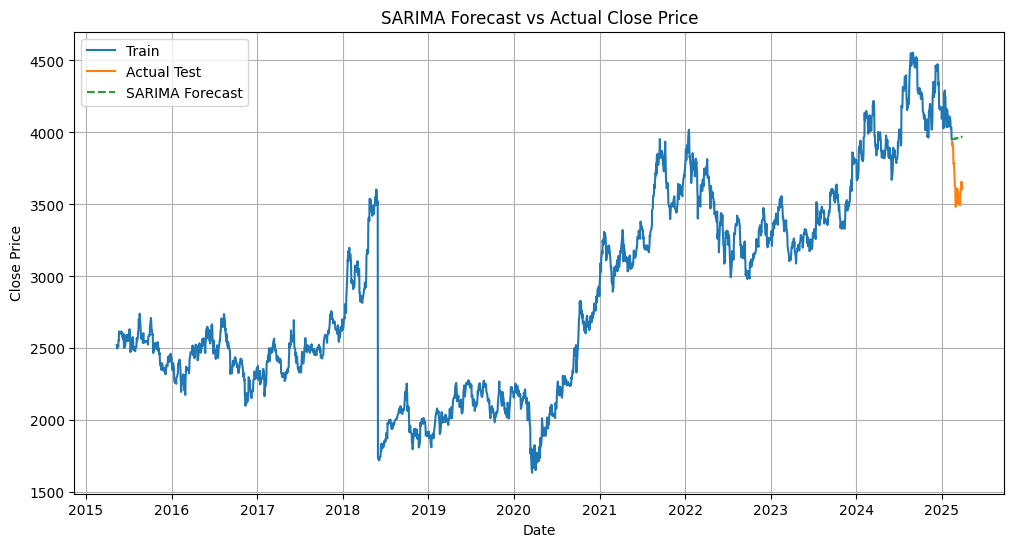

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Load your preprocessed data
ts = df["Close_Price"]

# 2. Train/Test Split  (no shuffling)
test_size = 30    # forecast last 30 days
train = ts[:-test_size]
test  = ts[-test_size:]

print("Train size:", len(train))
print("Test size:",  len(test))

# 2. Define seasonal period (important)
# Weekly seasonality in stock prices → s = 5
s = 5

# 3. Grid search for SARIMA (p,d,q) × (P,D,Q,s)
# Only a small grid to avoid heavy computation
p = d = q = range(0, 2)     # 0 or 1
P = D = Q = range(0, 2)

best_aic = np.inf
best_params = None

for i in p:
    for j in d:
        for k in q:
            for I in P:
                for J in D:
                    for K in Q:
                        try:
                            model = SARIMAX(train,
                                            order=(i, j, k),
                                            seasonal_order=(I, J, K, s),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=False)
                            if model.aic < best_aic:
                                best_aic = model.aic
                                best_params = (i, j, k, I, J, K)
                        except:
                            continue

print("\nBest SARIMA order found:")
print(f"Non-seasonal (p,d,q) = ({best_params[0]}, {best_params[1]}, {best_params[2]})")
print(f"Seasonal   (P,D,Q,s) = ({best_params[3]}, {best_params[4]}, {best_params[5]}, {s})")
print("Best AIC:", best_aic)

# 4. Fit the best SARIMA model
best_model = SARIMAX(train,
                     order=(best_params[0], best_params[1], best_params[2]),
                     seasonal_order=(best_params[3], best_params[4], best_params[5], s),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()

print("\nMODEL SUMMARY:\n")
print(best_model.summary())

# 5. Forecast over test horizon
start = len(train)
end   = len(train) + len(test) - 1

sarima_pred = best_model.predict(start=start, end=end)

# 6. Error metrics
rmse = np.sqrt(mean_squared_error(test, sarima_pred))
mae  = mean_absolute_error(test, sarima_pred)

print("\n====== TEST ERRORS ======")
print("RMSE:", rmse)
print("MAE :", mae)

# 7. Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index,  test,  label="Actual Test")
plt.plot(test.index,  sarima_pred, label="SARIMA Forecast", linestyle='--')
plt.title("SARIMA Forecast vs Actual Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()



====== SARIMA TEST ERRORS ======
MAE   : 320.418
RMSE  : 347.596


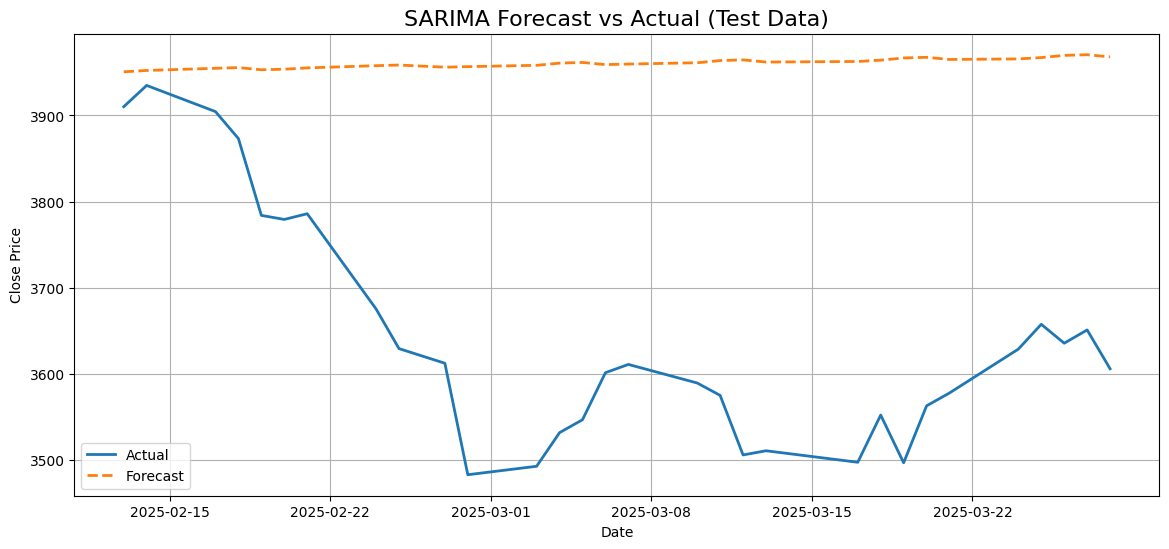

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Compute Test Error Metrics
rmse = np.sqrt(mean_squared_error(test, sarima_pred))
mae  = mean_absolute_error(test, sarima_pred)
mape = np.mean(np.abs((test - sarima_pred) / test)) * 100

print("\n====== SARIMA TEST ERRORS ======")
print(f"MAE   : {mae:.3f}")
print(f"RMSE  : {rmse:.3f}")

# 2. Forecast vs Actual Plot (Test Only)
plt.figure(figsize=(14,6))

plt.plot(test.index, test, label="Actual", linewidth=2)
plt.plot(test.index, sarima_pred, label="Forecast", linestyle="--", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test Data)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()

plt.show()


In [36]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# SAFE MAPE FUNCTION (avoids NaN when actual = 0)
def safe_mape(actual, pred):
    actual = np.array(actual)
    pred   = np.array(pred)

    mask = actual != 0        # ignore zero actual values
    return np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100


train_pred = best_model.predict(start=0, end=len(train)-1)

train_rmse = np.sqrt(mean_squared_error(train, train_pred))
train_mae  = mean_absolute_error(train, train_pred)
train_mape = safe_mape(train, train_pred)


# 2. TEST PREDICTIONS (Out-of-sample)
test_rmse = np.sqrt(mean_squared_error(test, sarima_pred))
test_mae  = mean_absolute_error(test, sarima_pred)
test_mape = safe_mape(test, sarima_pred)


print("\n====== SARIMA TRAIN ERRORS ======")
print(f"SARIMA Train RMSE : {train_rmse:.3f}")
print(f"SARIMA Train MAE  : {train_mae:.3f}")
print(f"SARIMA Train MAPE : {train_mape:.3f}%")

print("\n====== SARIMA TEST ERRORS ======")
print(f"SARIMA Test RMSE  : {test_rmse:.3f}")
print(f"SARIMA Test MAE   : {test_mae:.3f}")
print(f"SARIMA Test MAPE  : {test_mape:.3f}%")



====== SARIMA TRAIN ERRORS ======
SARIMA Train RMSE : 82.933
SARIMA Train MAE  : 32.576
SARIMA Train MAPE : 1.186%

====== SARIMA TEST ERRORS ======
SARIMA Test RMSE  : 347.596
SARIMA Test MAE   : 320.418
SARIMA Test MAPE  : 8.942%


**Moving Average Forecasting Model**

Train size: 2413
Test size: 30

====== Moving Average Forecast Errors ======
MAE : 74.15233333333327
RMSE: 88.20194398840269


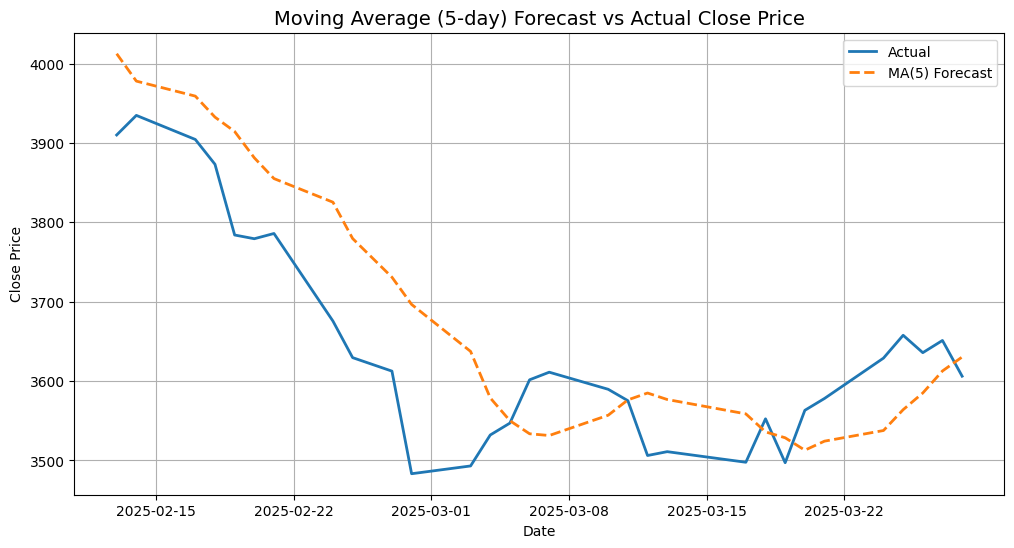

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

ts = df["Close_Price"]

test_size = 30
train = ts[:-test_size]
test = ts[-test_size:]

train_values = train.values
test_values = test.values

print("Train size:", len(train))
print("Test size:", len(test))

# 3. Moving Average Window
window = 5
predictions = []
history = list(train_values)

for t in range(len(test_values)):
    if len(history) < window:
        yhat = np.mean(history)
    else:
        yhat = np.mean(history[-window:])
    predictions.append(yhat)

    # update with actual value
    history.append(test_values[t])

mae = mean_absolute_error(test_values, predictions)
rmse = np.sqrt(mean_squared_error(test_values, predictions))

print("\n====== Moving Average Forecast Errors ======")
print("MAE :", mae)
print("RMSE:", rmse)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test_values, label='Actual', linewidth=2)
plt.plot(test.index, predictions, '--', label=f'MA({window}) Forecast', linewidth=2)
plt.title(f"Moving Average ({window}-day) Forecast vs Actual Close Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.show()


In [38]:

# Compute fitted values for training set
train_fitted = []

for i in range(len(train_values)):
    if i < window:
        yhat = np.mean(train_values[:i+1])
    else:
        yhat = np.mean(train_values[i-window:i])
    train_fitted.append(yhat)

train_resid = train_values - np.array(train_fitted)

train_mse  = np.mean(train_resid ** 2)
train_rmse = np.sqrt(train_mse)

print("Training MSE :", train_mse)
print("Training RMSE:", train_rmse)

pred_values = np.array(predictions)   # from MA forecasting loop
test_vals   = np.array(test_values)

mse  = np.mean((test_vals - pred_values) ** 2)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(test_vals - pred_values))
mape = np.mean(np.abs((test_vals - pred_values) / test_vals)) * 100

print("\n====== Forecast Error Metrics ======")
print("Forecast MSE :", mse)
print("Forecast RMSE:", rmse)
print("Forecast MAE :", mae)
print("Forecast MAPE:", mape)


Training MSE : 6727.102851292765
Training RMSE: 82.01891764277778

====== Forecast Error Metrics ======
Forecast MSE : 7779.582923333324
Forecast RMSE: 88.20194398840269
Forecast MAE : 74.15233333333327
Forecast MAPE: 2.0385333741202283


**Bonus section : Long short term memory (machine learning)**

Train sequences: (2393, 20, 1)
Test sequences: (30, 20, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0206 - val_loss: 0.0020
Epoch 2/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.5271e-04 - val_loss: 0.0021
Epoch 3/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013 - val_loss: 9.0380e-04
Epoch 4/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4703e-04 - val_loss: 9.6187e-04
Epoch 5/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8690e-04 - val_loss: 6.7126e-04
Epoch 6/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 8.0932e-04 - val_loss: 8.3319e-04
Epoch 7/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0016 - val_loss: 5.5146e-04
Epoch 8/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.9881e-04 - val_loss: 6.4625e-04
Epoch 9/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.2027e-04 - val_loss: 6.0083e-04
Epoch 10/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.7719e-04 - val_loss: 5.3682e-04
Epoch 11/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.8610e-0

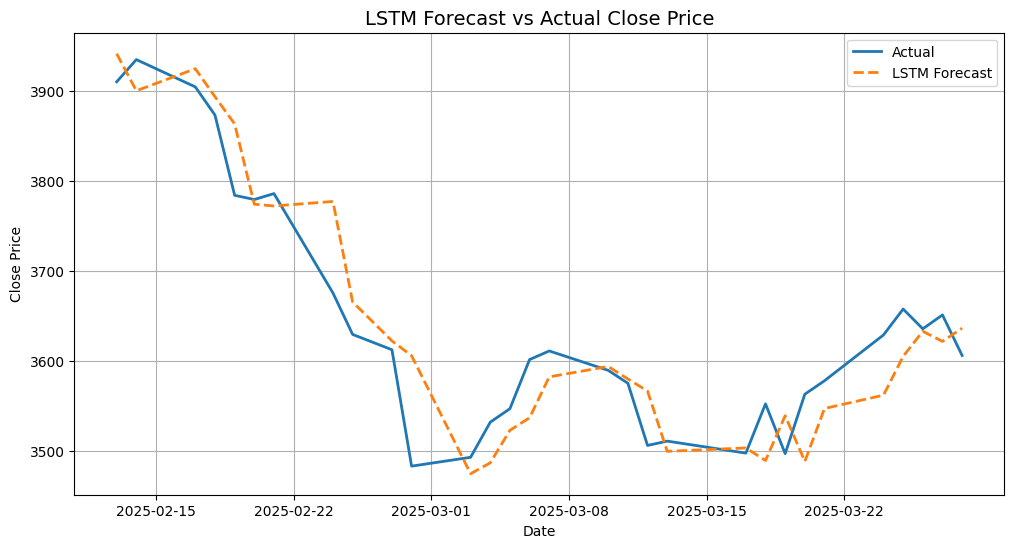

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
ts = df["Close_Price"].values.reshape(-1, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts)

test_size = 30
train = ts_scaled[:-test_size]
test  = ts_scaled[-test_size:]

# 4. Convert to supervised sequences
#    lookback = how many days of history the LSTM sees
lookback = 20

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train, lookback)
X_test,  y_test  = create_sequences(ts_scaled[-(test_size + lookback):], lookback)

# reshape to LSTM input: [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0],  X_test.shape[1], 1)

print("Train sequences:", X_train.shape)
print("Test sequences:",  X_test.shape)

# 5. Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(lookback, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

# 6. Train the model
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

# 7. Forecast on test set
pred_scaled = model.predict(X_test)

# invert normalization
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# align to test index
test_index = df.index[-len(actual):]

# 8. Evaluation Metrics
mae = mean_absolute_error(actual, pred)
mse = mean_squared_error(actual, pred) # Calculate MSE first
rmse = np.sqrt(mse) # Then take the square root for RMSE

print("\n===== LSTM TEST ERRORS ====")
print("MAE :", mae)
print("RMSE:", rmse)

# 9. Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(test_index, actual, label="Actual", linewidth=2)
plt.plot(test_index, pred, label="LSTM Forecast", linestyle='--', linewidth=2)
plt.title("LSTM Forecast vs Actual Close Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.legend()
plt.show()

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


train_pred_scaled = model.predict(X_train)

# Inverse transform predictions and actuals for metric calculation on original scale
train_pred_original = scaler.inverse_transform(train_pred_scaled)
train_actual_original = scaler.inverse_transform(y_train.reshape(-1, 1))

train_rmse = np.sqrt(mean_squared_error(train_actual_original, train_pred_original))
train_mae  = mean_absolute_error(train_actual_original, train_pred_original)
train_mape = np.mean(np.abs((train_actual_original - train_pred_original) / train_actual_original)) * 100

print("LSTM Train RMSE:", train_rmse)
print("LSTM Train MAE :", train_mae)
print("LSTM Train MAPE:", train_mape)


test_rmse_lstm = np.sqrt(mean_squared_error(actual, pred))
test_mae_lstm  = mean_absolute_error(actual, pred)
test_mape_lstm = np.mean(np.abs((actual - pred) / actual)) * 100

print("LSTM Test RMSE:", test_rmse_lstm)
print("LSTM Test MAE :", test_mae_lstm)
print("LSTM Test MAPE:", test_mape_lstm)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM Train RMSE: 57.46647729994869
LSTM Train MAE : 33.70098362247963
LSTM Train MAPE: 1.2165475494459879
LSTM Test RMSE: 48.090548712326765
LSTM Test MAE : 37.831822916666624
LSTM Test MAPE: 1.044816505385725
